In [1]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open("names.txt",'r') as file:
    words = file.read().splitlines()

In [3]:
len(words)

32033

In [6]:
# build the vocab of char and map to ints
chars = sorted(list(set(''.join(words))))
stoi = {ch:i+1 for i,ch in enumerate(chars)}
stoi['.']=0
itos = {i:ch for ch,i in stoi.items()}
vocab_size=len(itos)

In [5]:
block_size = 3 # context len to predic the next char
    
def build_dataset(words):
    # build the dataset
    X,Y = [],[] # inputs, labels
    for w in words:
    #     print(w)
        context = [0]*block_size #padded context for start
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context) 
            Y.append(ix)
    #         print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:]+[ix] # crop & append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y
random.seed(42)
random.shuffle(words)
n1,n2 = int(len(words)*0.8),int(len(words)*0.9)
Xtr,Ytr = build_dataset(words[:n1])     # 80%
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])
# X,Y = Xtr,Ytr

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [107]:
# MLP again

n_embd = 10 # dimensionality of the embedding
n_hidden = 200 # number of neuroms of hidden layer


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd*block_size,n_hidden), generator=g)*(5/3)/((n_embd*block_size)**0.5)
# b1 = torch.randn(n_hidden, generator=g)*0.01

W2 = torch.randn((n_hidden, vocab_size), generator=g)*0.01
b2 = torch.randn(vocab_size, generator=g)*0 

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C,W1,W2,b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # num of params
for p in parameters:
    p.requires_grad=True

12097


In [108]:
hpreact.mean(0,keepdim=True).shape, hpreact.std(0,keepdim=True).shape


(torch.Size([1, 200]), torch.Size([1, 200]))

In [109]:
# same optimization as last part
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minbatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    Xb,Yb = Xtr[ix],Ytr[ix]

    # forward pass
    emb = C[Xb] # embed into vectors
    embcat = emb.view(emb.shape[0],-1) # concat the vectors
    hpreact = embcat @ W1 # + b1 # hidden layer pre-activation
    # Batch normalization : make this gaussian
    bnmeani = hpreact.mean(0,keepdim=True)
    bnstdi = hpreact.std(0,keepdim=True)
    hpreact = bngain* (hpreact - bnmeani)/bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    # non-linearity
    h = torch.tanh(hpreact) # hidden layer    
    logits = h@W2 + b2 # output layer
    loss = F.cross_entropy(logits,Yb) # loss func
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i<100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr*p.grad
        
    # track 
    if i%1000==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
#     break

      0/ 200000: 3.3151
   1000/ 200000: 2.4314
   2000/ 200000: 2.4524
   3000/ 200000: 2.0722
   4000/ 200000: 2.5837
   5000/ 200000: 2.3996
   6000/ 200000: 2.4165
   7000/ 200000: 2.4501
   8000/ 200000: 2.4143
   9000/ 200000: 2.5706
  10000/ 200000: 2.2022
  11000/ 200000: 2.3992
  12000/ 200000: 2.4041
  13000/ 200000: 2.2935
  14000/ 200000: 2.2762
  15000/ 200000: 2.1657
  16000/ 200000: 1.9178
  17000/ 200000: 2.0474
  18000/ 200000: 2.1872
  19000/ 200000: 2.1789
  20000/ 200000: 2.3149
  21000/ 200000: 2.4007
  22000/ 200000: 2.2472
  23000/ 200000: 2.2536
  24000/ 200000: 2.2914
  25000/ 200000: 2.3061
  26000/ 200000: 2.4363
  27000/ 200000: 2.0855
  28000/ 200000: 2.0900
  29000/ 200000: 2.4341
  30000/ 200000: 2.3223
  31000/ 200000: 2.2168
  32000/ 200000: 1.8385
  33000/ 200000: 1.9324
  34000/ 200000: 2.2763
  35000/ 200000: 2.4801
  36000/ 200000: 2.3597
  37000/ 200000: 2.4105
  38000/ 200000: 2.3691
  39000/ 200000: 2.4825
  40000/ 200000: 2.3636
  41000/ 200000:

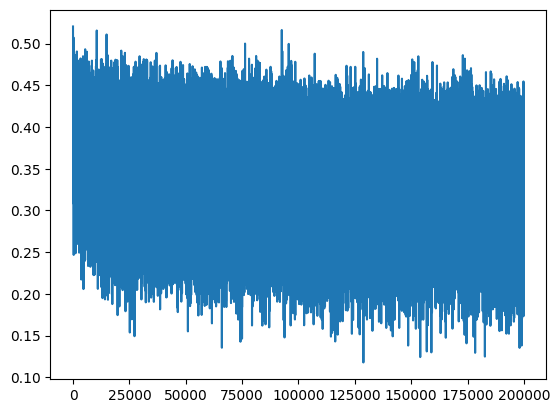

In [110]:
# plt.plot(lossi)

In [111]:
# calibrate batch norm at end of training
# with torch.no_grad():
#     # pass the train set
#     emb = C[Xtr]
#     embcat = emb.view(emb.shape[0],-1)
#     hpreact = embcat @ W1 + b1
#     # measure mean/std over entire training set
#     bnmean = hpreact.mean(0,keepdim=True)
#     bnstd = hpreact.std(0,keepdim=True)

In [112]:
@torch.no_grad() # disables grad tracking 
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test': (Xte,Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat@W1 + b1
    hpreact = bngain* (hpreact - bnmean_running)/bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h@W2+b2
    loss = F.cross_entropy(logits,y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0683505535125732
val 2.1079013347625732


In [113]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0]*block_size # init ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        hpreact = emb.view(1,-1)@W1+b1
        hpreact = bngain* (hpreact - bnmean_running)/bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h@W2+b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,num_samples=1,generator=g).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix==0:
            break
    print(''.join(itos[i] for i in out))

carmahzaal.
havi.
kimritheatlanna.
sane.
mahnen.
delynn.
jareei.
nellara.
chaiir.
kaleigh.
ham.
joce.
quint.
shon.
malian.
quinterri.
jarynix.
kaellinslee.
dae.
iia.


In [114]:
# Summary

In [207]:
# Train a deeper network

class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in,fan_out), generator=g) #/ fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momemtum=0.1):
        self.eps = eps
        self.momemtum = momemtum
        self.training = True
        # params (trained with backprop)
        self.gamma = torch.ones(dim) # y = BN(gamma) + beta
        self.beta = torch.zeros(dim)
        # buffer (trained with a running 'momemtum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calc the forward pass
        if self.training:
            xmean = x.mean(0,keepdim=True) # batch mean
            xvar = x.var(0,keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean)/torch.sqrt(xvar-self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta # y = BN*gamma + beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momemtum) * self.running_mean + self.momemtum * xmean
                self.running_var = (1-self.momemtum) * self.running_var + self.momemtum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    


In [215]:
n_embd =10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size,n_embd), generator = g)

layers = [
    Linear(n_embd*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # last_layer: make less confident
#     layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # all other layers, apply gain
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *= 1 # 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # num of params in total

for p in parameters:
    p.requires_grad = True

47551


In [216]:
# training mode

max_steps = 200000
batch_size = 32
lossi = []
ud = []
for i in range(max_steps):
    
    # minibatch construct 
    ix = torch.randint(0,Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed char into vectors
    x = emb.view(emb.shape[0],-1) # concat the vector
    for idx,layer in enumerate(layers):
#         print(idx,layer)
        x = layer(x)
    loss = F.cross_entropy(x,Yb) # loss func
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain graph
    for p in parameters:
        p.grad = None # zero grad
    loss.backward()
    
    # update
    lr = 1.0 if i <max_steps/2 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track data
    if i%1000 == 0: #print once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i>1000:
        break # AFTER_DEBUG: would take out to run fully

      0/ 200000: 3.2870
   1000/ 200000: 2.3263


layer 2 (Tanh): mean 0.02, std: 0.63, saturated: 4.25%
layer 5 (Tanh): mean -0.01, std: 0.63, saturated: 3.06%
layer 8 (Tanh): mean -0.02, std: 0.64, saturated: 3.28%
layer 11 (Tanh): mean -0.01, std: 0.63, saturated: 3.09%
layer 14 (Tanh): mean 0.02, std: 0.64, saturated: 3.31%


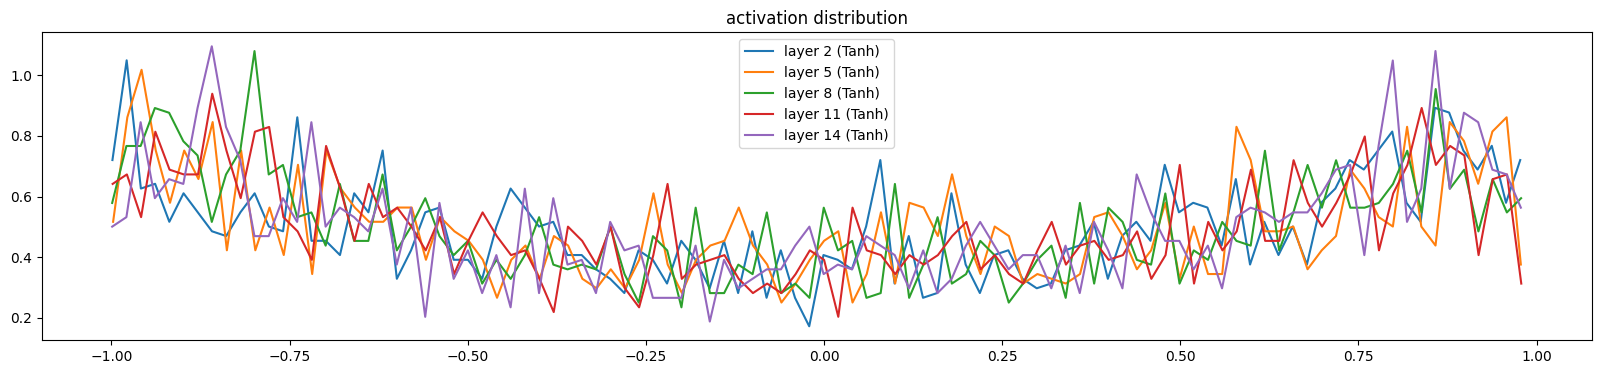

In [217]:
# visualize histograms for tanh layers

plt.figure(figsize=(20,4)) # w/h of plot
legends = []
for i, layer in enumerate(layers[:-1]): # exlcude output layer
    if isinstance(layer, Tanh):
        t=layer.out
        print(f'layer {i} ({layer.__class__.__name__}): mean {t.mean():.2f}, std: {t.std():.2f}, saturated: {(t.abs()>0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution');

layer 2 (Tanh): mean -0.000000, std: 0.004361, saturated: 0.00000000%
layer 5 (Tanh): mean 0.000000, std: 0.003805, saturated: 0.00000000%
layer 8 (Tanh): mean -0.000000, std: 0.003511, saturated: 0.00000000%
layer 11 (Tanh): mean 0.000000, std: 0.003270, saturated: 0.00000000%
layer 14 (Tanh): mean -0.000000, std: 0.003145, saturated: 0.00000000%


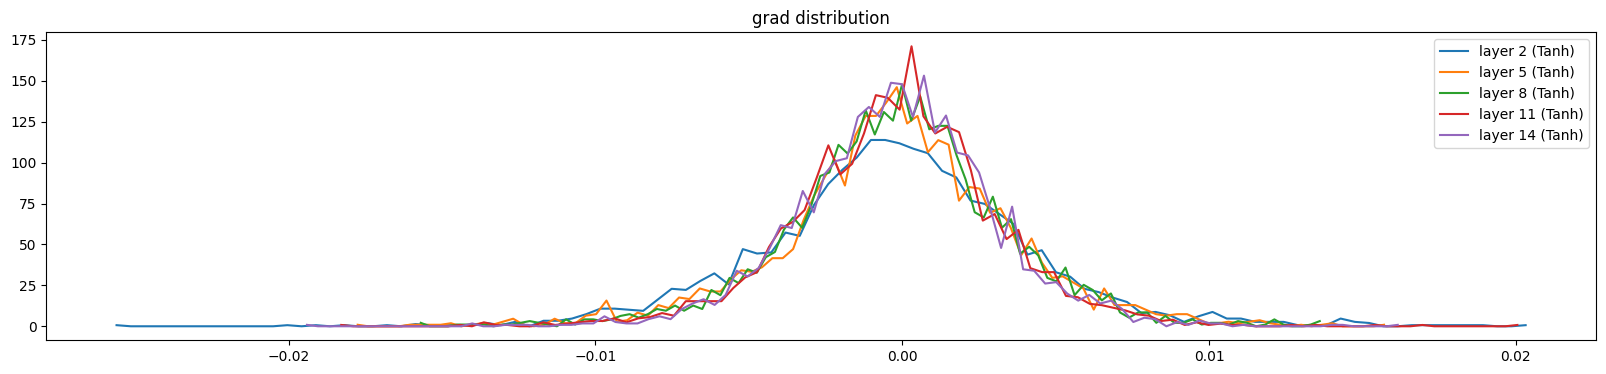

In [218]:
# visualize histograms for tanh layer grad

plt.figure(figsize=(20,4)) # w/h of plot
legends = []
for i, layer in enumerate(layers[:-1]): # exlcude output layer
    if isinstance(layer, Tanh):
        t=layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__}): mean {t.mean():.6f}, std: {t.std():.6f}, saturated: {(t.abs()>0.97).float().mean()*100:.8f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('grad distribution');

layer 2 (Tanh): mean 0.02, std: 0.63, saturated: 4.25%
layer 5 (Tanh): mean -0.01, std: 0.63, saturated: 3.06%
layer 8 (Tanh): mean -0.02, std: 0.64, saturated: 3.28%
layer 11 (Tanh): mean -0.01, std: 0.63, saturated: 3.09%
layer 14 (Tanh): mean 0.02, std: 0.64, saturated: 3.31%


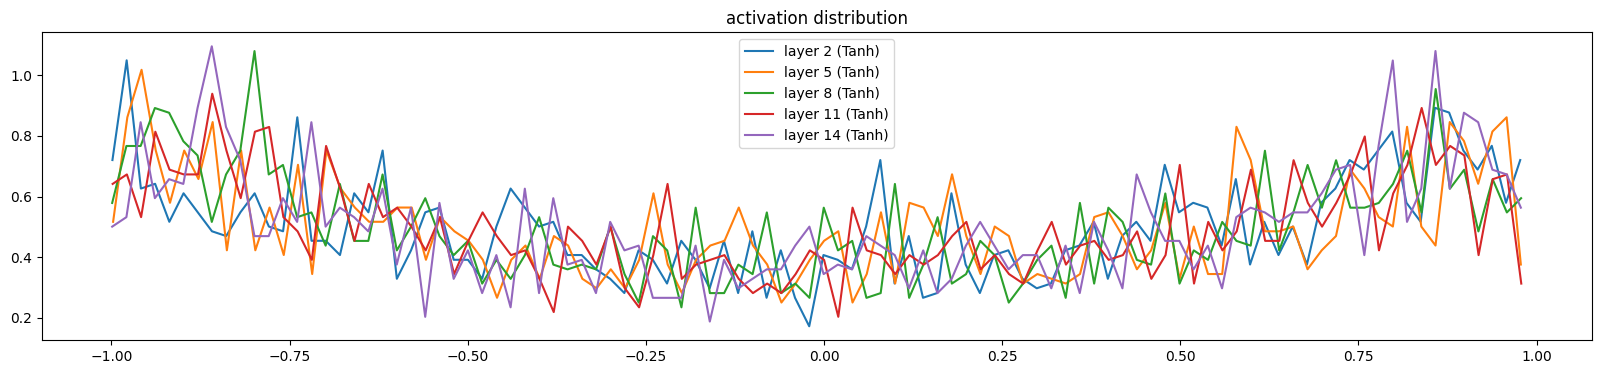

In [219]:
# visualize histograms for tanh layers

plt.figure(figsize=(20,4)) # w/h of plot
legends = []
for i, layer in enumerate(layers[:-1]): # exlcude output layer
    if isinstance(layer, Tanh):
        t=layer.out
        print(f'layer {i} ({layer.__class__.__name__}): mean {t.mean():.2f}, std: {t.std():.2f}, saturated: {(t.abs()>0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution');

weight (27, 10) | mean 0.000000, std: 0.008547, grad:data ratio: 8.2839E-03%
weight (30, 100) | mean -0.000005, std: 0.002679, grad:data ratio: 2.6067E-03%
weight (100, 100) | mean 0.000026, std: 0.001377, grad:data ratio: 1.3802E-03%
weight (100, 100) | mean 0.000004, std: 0.001261, grad:data ratio: 1.2510E-03%
weight (100, 100) | mean 0.000012, std: 0.001098, grad:data ratio: 1.0937E-03%
weight (100, 100) | mean -0.000011, std: 0.001066, grad:data ratio: 1.0614E-03%
weight (100, 27) | mean -0.000035, std: 0.001969, grad:data ratio: 1.9884E-03%


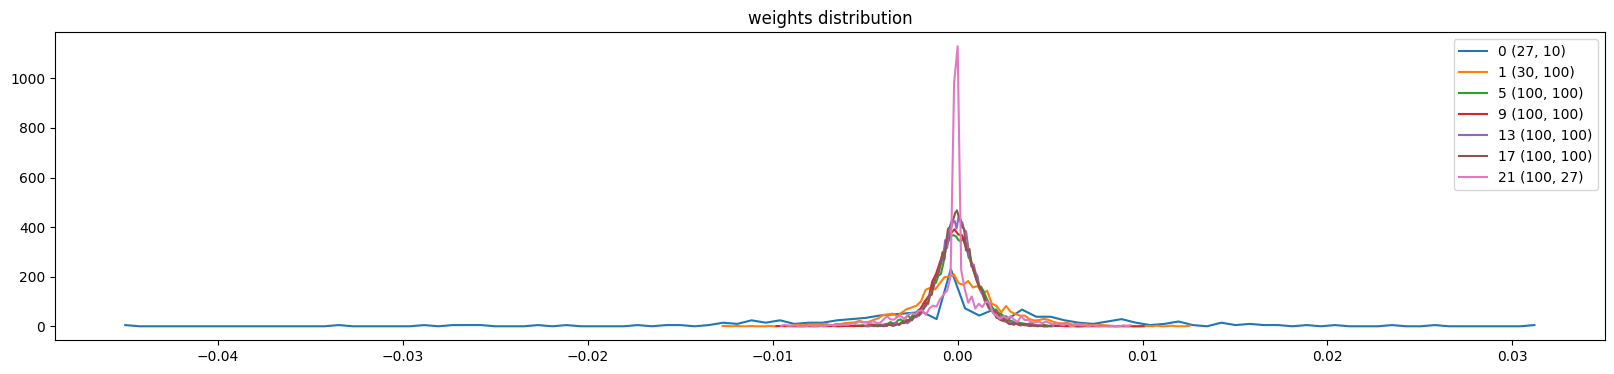

In [220]:
# visualize histograms

plt.figure(figsize=(20,4)) # w/h of plot
legends = []
for i, p in enumerate(parameters):
    t=p.grad
    if p.ndim==2: # only for weights
        print(f'weight {tuple(p.shape)} | mean {t.mean():.6f}, std: {t.std():.6f}, grad:data ratio: {t.std()/p.std():.4E}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights distribution');

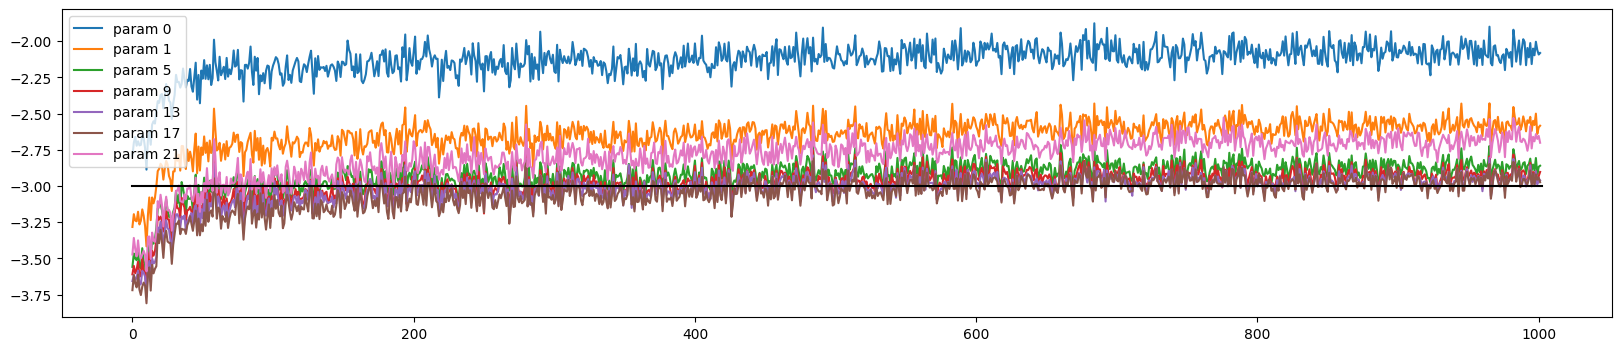

In [221]:
# evolution of update ratio 
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param {i}')
plt.plot([0,len(ud)],[-3,-3],'k') # ratios should be ~1e-3, indicate on plot 
plt.legend(legends);